<a href="https://colab.research.google.com/github/AmulyaReddy99/DNN/blob/master/Vectorized_NN_generic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import matplotlib.colors
from tqdm import tqdm_notebook
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1. Data

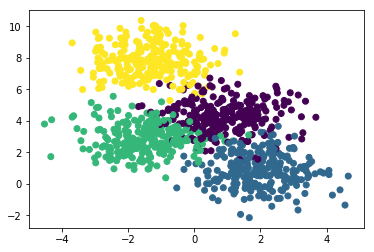

In [0]:
# Create data
from sklearn.datasets import make_blobs

data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
labels_orig = labels
labels = np.mod(labels_orig, 4)

my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","green"])
plt.scatter(data[:,0], data[:,1], c=labels)
plt.show()

In [0]:
# onehotencoding of the labels
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(labels.reshape(-1,1))
Y

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, stratify=Y, random_state=0)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(750, 2) (750, 4) (250, 2) (250, 4)


## 2. Generic Neural Network Class

In [0]:
class NeuralNetwork:
  
  def __init__(self,n_input=2,hidden = [2],output=1, W1=None,W2=None,init_method='random',activation = 'sigmoid',leaky_slope=0.01):
    self.neurons = [n_input] + hidden + [output]
    
    # forward pass
    self.W = {}
    self.B = {}
    self.A = {}
    self.H = {}
    # grads
    self.dA = {}
    self.dW = {}
    self.dH = {}
    self.dB = {}
    
    # for storing the history 
    self.error_h = []
    self.W_h = []
    self.B_h = []
    self.output = output
    self.accu_train = {}
    self.accu_val = {}
        
    self.accuracy = 0
    
    # initialize the weights         
    if init_method == 'random':
      for i in range(len(self.neurons)-1):
        self.W[i+1] = np.random.rand(self.neurons[i],self.neurons[i+1])
        self.B[i+1] = np.random.rand(1,self.neurons[i+1])
     
    if init_method == 'zeros':
      for i in range(len(self.neurons)-1):
        self.W[i+1] = np.zeros(shape=(self.neurons[i],self.neurons[i+1]))
        self.B[i+1] = np.zeros(shape=(1,self.neurons[i+1]))
       
    if init_method == 'xavier':
      for i in range(len(self.neurons)-1):
        self.W[i+1] = np.random.rand(self.neurons[i],self.neurons[i+1]) / np.sqrt(self.neurons[i])
        self.B[i+1] = np.random.rand(1,self.neurons[i+1]) / np.sqrt(self.neurons[i])
                
    if init_method == 'he':
      for i in range(len(self.neurons)-1):
        self.W[i+1] = np.random.rand(self.neurons[i],self.neurons[i+1]) / np.sqrt(self.neurons[i]/2)
        self.B[i+1] = np.random.rand(1,self.neurons[i+1]) / np.sqrt(self.neurons[i])
        
    self.activation = activation
    self.leaky_slope = leaky_slope

  def activation_function(self,X):
    
    if self.activation == 'sigmoid':
      return 1.0/(1.0+np.exp(-X))
      
    if self.activation == 'tanh':
      return np.tanh(X)
    
    if self.activation == 'relu':
      return np.maximum(0,X)  # Element-wise maximum of array elements
    
    if self.activation == 'leaky_relu':
      return np.maximum(self.leaky_slope*X,X)
    
    
  def grad_activation(self,X):
    if self.activation == 'sigmoid':
      return np.multiply(X,(1-X))
    elif self.activation == 'tanh':
      return (1-np.square(X))
    elif self.activation == 'relu':
      return 1.0*(X>0)
    elif self.activation == 'leaky_relu':
      out = np.zeros(shape=X.shape)
      out[X<=0] = self.leaky_slope
      out[X>0] = 1
      return out
      
  def softmax(self,X):
    exps = np.exp(X)
    sums = np.sum(exps,axis=1).reshape(-1,1)
    return exps/sums
    
  def forward_pass(self,X):
    self.H[0] = X
    for i in self.W.keys():
      self.A[i] = np.matmul(self.H[i-1],self.W[i]) + self.B[i]
      
      if i == len(self.neurons)-1 and self.output > 1:
        self.H[i] = self.softmax(self.A[i])
      else:
        self.H[i] = self.activation_function(self.A[i])
           
    return self.H[len(self.neurons)-1]
 
  def grad(self,X,Y,W=None,B=None):
    
    if W is None:
      W = self.W
    if B is None:
      B = self.B
    
    self.forward_pass(X)
    Y = Y.reshape(-1,self.output)
    
    # Backpropation for the last layer 
    self.dA[len(self.neurons)-1] = np.multiply((self.H[len(self.neurons)-1] - Y), self.grad_activation(self.H[len(self.neurons)-1]))  # (M,N).*(M,N) = (M,N)
    
    if self.loss == 'ce':
      self.dA[len(self.neurons)-1] = self.H[len(self.neurons)-1] - Y # (N,1) 
    
    self.dW[len(self.neurons)-1] = np.matmul(self.H[len(self.neurons)-2].T,self.dA[len(self.neurons)-1]) 
    self.dB[len(self.neurons)-1] = np.sum(self.dA[len(self.neurons)-1],axis=0).reshape(1,-1)
    
    
    # backpropation for hidden layers to input
    for i in range(len(self.neurons)-2,0,-1):
      self.dH[i] = np.matmul(self.dA[i+1],W[i+1].T) 
      self.dA[i] = np.multiply(self.dH[i],self.grad_activation(self.H[i]))
      self.dW[i]= np.matmul(self.H[i-1].T,self.dA[i])
      self.dB[i] = np.sum(self.dA[i],axis=0).reshape(1,-1)
      
  def initialise_params(self,algo='GD',gamma=0.9):
    if algo != 'GD':
      self.V_W = {}
      self.V_B = {}
      for j in self.W.keys():
        self.V_W[j] = 0
        self.V_B[j] = 0
        
    if algo == 'NAG':
      self.W_T = {}
      self.B_T = {}
      for j in self.W.keys():
        self.W_T[j] = self.W[j] - gamma*self.V_W[j]
        self.B_T[j] = self.B[j] - gamma*self.V_B[j]
        
    if algo == "Adam":
      self.M_W = {}
      self.M_B = {}
      
      for j in self.W.keys():
        self.M_W[j] = 0
        self.M_B[j] = 0
        
  def get_accuracy(self,X=None,Y=None):
    
    if X is None:
      X = self.X
    if Y is None:
      Y = self.Y
      
    if self.output > 1:
      accuracy = accuracy_score(np.argmax(Y,axis=1),np.argmax(self.predict(X),axis=1))
    else:
      accuracy = accuracy_score(Y,(self.predict(X)>=0.5).astype(int))

    return accuracy

        
  def error(self,X=None,Y=None):
    if X is None:
      X = self.X
    if Y is None:
      Y = self.Y
    Y_pred = self.forward_pass(X)
    
    if self.loss == 'ce':
      return log_loss(Y,Y_pred)

    return mean_squared_error(Y,Y_pred)
    
  
  def fit(self,X,Y,X_val=None,Y_val=None,epochs=100,learning_rate=0.1,display_loss=True,loss='mse',algo='GD',batch_size=32,gamma=0.9,eps=1e-8,beta=0.9,beta1=0.9,beta2=0.99):
    
    self.loss = loss      
    self.X = X
    self.Y = Y.reshape(-1,self.output)
    m = self.X.shape[0]
    
    self.initialise_params(algo,gamma=gamma)
       
    if algo == "GD":
      for epoch in range(epochs):
        self.grad(X,Y)
        for i in self.W.keys():
          self.W[i] -= learning_rate*self.dW[i]/m
          self.B[i] -= learning_rate*self.dB[i]/m
        self.append_log()
        self.accu_train[epoch] = self.get_accuracy()
        if X_val is not None and Y_val is not None:
          self.accu_val[epoch] = self.get_accuracy(X_val,Y_val)
      
    if algo == 'MiniBatch':
      X_batch,Y_batch = X[0:batch_size], Y[0:batch_size]
      for epoch in range(epochs):
        j = 0
        while (len(X[j:j+batch_size]) != 0):
          X_batch,Y_batch = X[j:j+batch_size], Y[j:j+batch_size]
          self.grad(X_batch,Y_batch)
          for i in self.W.keys():
            self.W[i] -= learning_rate*self.dW[i]/batch_size
            self.B[i] -= learning_rate*self.dB[i]/batch_size
          j = j + batch_size
        self.append_log(X_batch,Y_batch)
        self.accu_train[epoch] = self.get_accuracy()
        if X_val is not None and Y_val is not None:
          self.accu_val[epoch] = self.get_accuracy(X_val,Y_val)
        
    if algo == "Momentum":
      for epoch in range(epochs):
        self.grad(X,Y)
        for j in self.W.keys():
          self.V_W[j] = gamma*self.V_W[j] + learning_rate*self.dW[j]/m
          self.V_B[j] = gamma*self.V_B[j] + learning_rate*self.dB[j]/m    
          self.W[j] -= self.V_W[j]
          self.B[j] -= self.V_B[j]
        self.append_log()
        self.accu_train[epoch] = self.get_accuracy()
        if X_val is not None and Y_val is not None:
          self.accu_val[epoch] = self.get_accuracy(X_val,Y_val)
        
        
    if algo == 'NAG':      
      for epoch in range(epochs):
        self.grad(X,Y,W=self.W_T,B=self.B_T)
        for j in self.W.keys():
          self.V_W[j] = gamma*self.V_W[j] + learning_rate*self.dW[j]/m
          self.V_B[j] = gamma*self.V_B[j] + learning_rate*self.dB[j]/m
          
          self.W_T[j] = self.W[j] - gamma*self.V_W[j]
          self.B_T[j] = self.B[j] - gamma*self.V_B[j]
          
          self.W[j] -= self.V_W[j]
          self.B[j] -= self.V_B[j]
        self.append_log()
        self.accu_train[epoch] = self.get_accuracy()
        if X_val is not None and Y_val is not None:
          self.accu_val[epoch] = self.get_accuracy(X_val,Y_val)
        
        
    if algo == 'Adagrad':        
      for epoch in range(epochs):
        self.grad(X,Y)
        for j in self.W.keys():
          self.V_W[j] += np.square(self.dW[j])
          self.V_B[j] += np.square(self.dB[j])
          self.W[j] -= learning_rate * self.dW[j] / (np.sqrt(self.V_W[j])+eps)
          self.B[j] -= learning_rate * self.dB[j] / (np.sqrt(self.V_B[j])+eps)
      
        self.append_log()
        self.accu_train[epoch] = self.get_accuracy()
        if X_val is not None and Y_val is not None:
          self.accu_val[epoch] = self.get_accuracy(X_val,Y_val)
        
    if algo == 'RMSProp':        
      for epoch in range(epochs):
        self.grad(X,Y)
        for j in self.W.keys():
          self.V_W[j] = beta*self.V_W[j] + (1-beta)*np.square(self.dW[j])
          self.V_B[j] = beta*self.V_B[j] + (1-beta)*np.square(self.dB[j])
          
          self.W[j] -= learning_rate * self.dW[j] / (np.sqrt(self.V_W[j])+eps)
          self.B[j] -= learning_rate * self.dB[j] / (np.sqrt(self.V_B[j])+eps)
      
        self.append_log()
        self.accu_train[epoch] = self.get_accuracy()
        if X_val is not None and Y_val is not None:
          self.accu_val[epoch] = self.get_accuracy(X_val,Y_val)
      
    if algo == 'Adam':        
      for epoch in range(epochs):
        self.grad(X,Y)
        for j in self.W.keys():
          self.M_W[j] = beta1*self.M_W[j] + (1-beta1)*self.dW[j]
          self.M_B[j] = beta1*self.M_B[j] + (1-beta1)*self.dB[j]
          self.V_W[j] = beta2*self.V_W[j] + (1-beta2)*np.square(self.dW[j])
          self.V_B[j] = beta2*self.V_B[j] + (1-beta2)*np.square(self.dB[j])
          
          self.W[j] -= learning_rate * self.M_W[j] / (np.sqrt(self.V_W[j])+eps)
          self.B[j] -= learning_rate * self.M_B[j] / (np.sqrt(self.V_B[j])+eps)
      
        self.append_log()
        self.accu_train[epoch] = self.get_accuracy()
        if X_val is not None and Y_val is not None:
          self.accu_val[epoch] = self.get_accuracy(X_val,Y_val)
        
    if display_loss:
      plt.plot(self.accu_train.values())
      plt.plot(self.accu_val.values())
      plt.xlabel('Iterations')
      plt.ylabel('Accuracy')
      plt.title('Algorithm: '+algo+' | Activation Function: '+self.activation)
      
    
  
  def predict(self,X):
    return self.forward_pass(X)
    
  def append_log(self,X=None,Y=None):
    if X is None:
      X = self.X
    if Y is None:
      Y = self.Y
    self.W_h.append(self.W)
    self.B_h.append(self.B)
    self.error_h.append(self.error(X,Y))
    

##3. Modelling

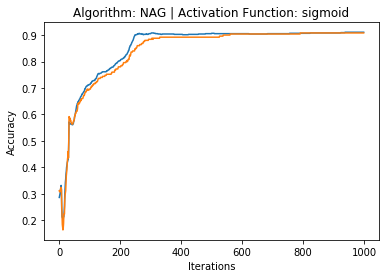

In [0]:
NN = NeuralNetwork(hidden=[2], output=4,init_method='random',activation='sigmoid',leaky_slope=0.01)
NN.fit(X_train,Y_train,X_test,Y_test,loss='ce',learning_rate=0.1,epochs=1000,display_loss=True,algo='NAG',batch_size=128,gamma=0.8,beta=0.9,beta1=0.5,beta2=0.5)

In [0]:
def accuracy(X,Y,model):
  Y_pred = model.predict(X)
  
  if model.output > 1:
      accuracy = accuracy_score(np.argmax(Y,axis=1),np.argmax(model.predict(X),axis=1))
  else:
      accuracy = accuracy_score(Y,(model.predict(X)>=0.5).astype(int))
 
  return accuracy


print('Accuracy score for training data set: ',accuracy(X_train,Y_train,NN))
print('Accuracy score for test data set: ',accuracy(X_test,Y_test,NN))

Accuracy score for training data set:  0.9306666666666666
Accuracy score for test data set:  0.924


##4. Visualisation of the network

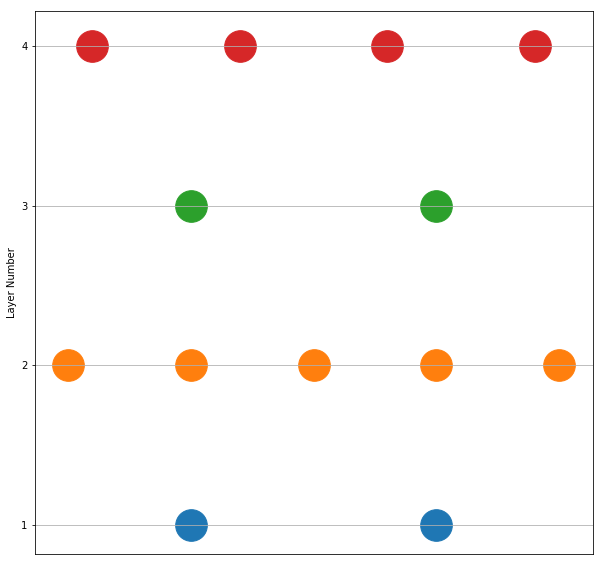

In [0]:
fig = plt.figure(figsize=(10,10))

for i,n in enumerate(NN.neurons):
  X = np.linspace(0,10,n+2)
  Y = [i+1]*len(X[1:-1])
  plt.scatter(X[1:-1],Y,s=1000)

plt.xticks([])

plt.yticks(list(range(1,len(NN.neurons)+1)))
plt.ylabel('Layer Number')
plt.grid(b=True)
plt.show()

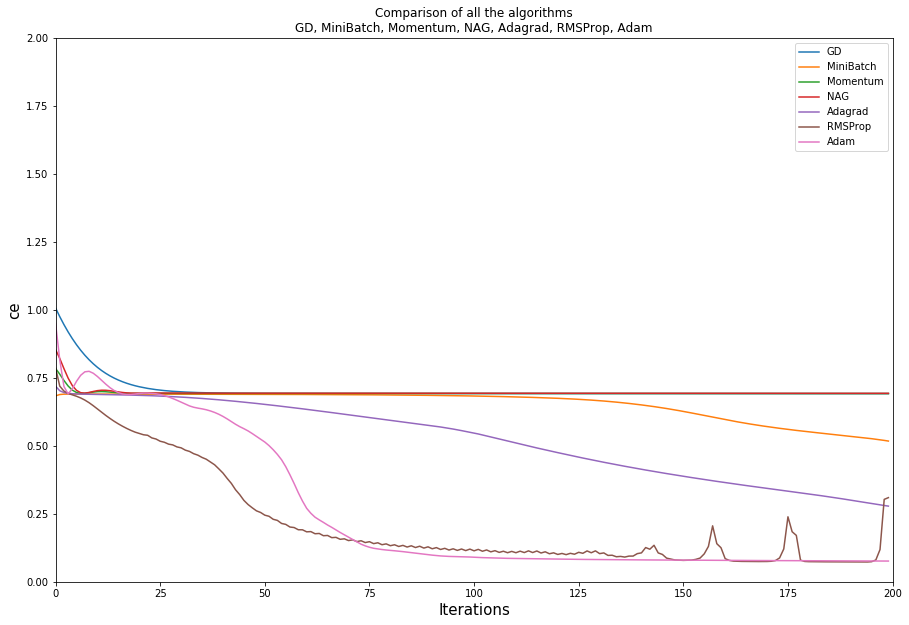

In [0]:
algos = ['GD','MiniBatch','Momentum','NAG','Adagrad','RMSProp','Adam']


loss = 'ce'
iterations = 200

fig = plt.figure(figsize=(15,10))
plt.xlabel('Iterations',fontsize=15)
plt.ylabel(loss,fontsize=15)
plt.title('Comparison of all the algorithms\n'+", ".join(algos))
plt.xlim(0,iterations)
plt.ylim(0,2)
for algo in algos:
  NN = NeuralNetwork(hidden=[5,2])
  NN.fit(X_train,Y_train,loss=loss,learning_rate=0.1,epochs=iterations,display_loss=False,algo=algo,batch_size=128,gamma=0.8,beta=0.9,beta1=0.9,beta2=0.99)
  plt.plot(range(len(NN.error_h)),NN.error_h,label=algo)

  
plt.legend()

## 5. Comparison of the algorithms and the activation functions

GD sigmoid
GD tanh
GD relu
GD leaky_relu
MiniBatch sigmoid
MiniBatch tanh
MiniBatch relu
MiniBatch leaky_relu
Adagrad sigmoid
Adagrad tanh
Adagrad relu
Adagrad leaky_relu
RMSProp sigmoid
RMSProp tanh
RMSProp relu
RMSProp leaky_relu
Adam sigmoid
Adam tanh
Adam relu
Adam leaky_relu


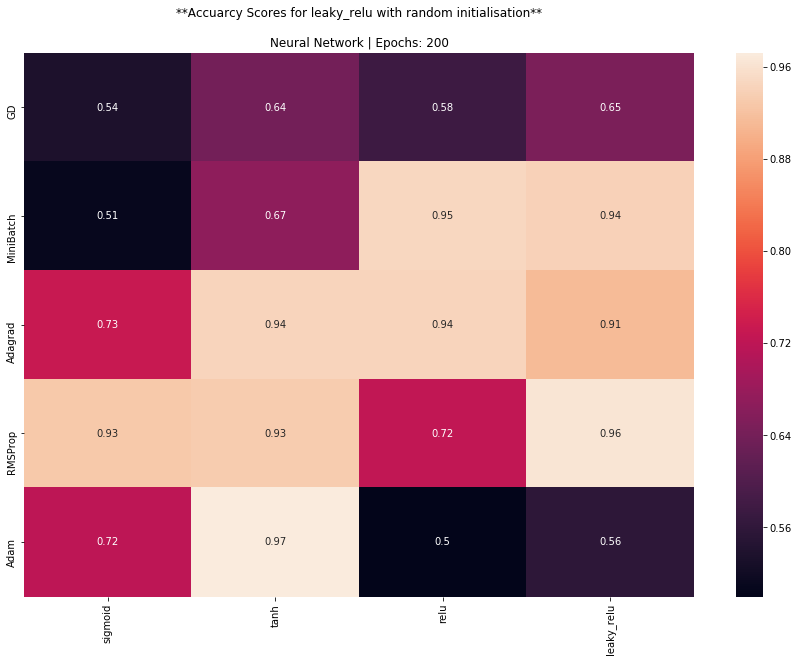

In [0]:
algos = ['GD',"MiniBatch",'Adagrad','RMSProp','Adam']
activation = ['sigmoid','tanh','relu','leaky_relu']

def compare_params(row,column,epochs=1000,learning_rate=0.1,init='random'):
  X1,Y1 = np.meshgrid(row,column)
  accuracies = np.zeros(shape=(len(row),len(column)))
  for i,r in enumerate(row):
    for j,c in enumerate(column):
      print(r,c)
      model = NeuralNetwork(hidden=[5,2],init_method='xavier',activation=c,leaky_slope=0.01)
      model.fit(X_test,Y_test,loss='ce',learning_rate=learning_rate,epochs=epochs,display_loss=False,algo=r,batch_size=128,gamma=0.9,beta=0.5,beta1=0.9,beta2=0.99)
      accuracies[i,j] = model.accuracy

  data = pd.DataFrame(accuracies,index=row,columns=column)
  plt.figure(figsize=(15,10))
  plt.title('**Accuarcy Scores for leaky_relu with '+init+' initialisation**\n\nNeural Network | Epochs: '+str(epochs))
  s = sns.heatmap(data,annot=True)
  s.set_xticklabels(labels = column, rotation=90)
  plt.show()
  return data
  
  
data = compare_params(row=algos,column=activation,epochs=200,learning_rate=0.1)

## 6. Practice

In [0]:
Y_true = np.array([1,0,0,0])
Y_pred = [0.09,0.01,0.02,0.02]
mean_squared_error(Y_true,Y_pred)

0.20725